# Задание 6

## Формулировка

Реализовать остаточную сверточную нейронную сеть с блоками слоев с соединениями напрямую (остаточными блоками).

Для выбранного датасета подберите параметры, при которых для построенной архитектуры достигается наивысшее качество классификации:

+ Количество эпох
+ Коэффициент обучения
+ Количество скрытых слоев (количество остаточных блоков)
+ Параметры kernel, stride, padding преобразований Conv2d и MaxPool2d
+ Количество скрытых слоев и нейронов в многослойном перцептроне на выходе

## Включение GPU

In [1]:
import torch

device = 'cpu'

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device: {torch.cuda.current_device()}")
    print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

    device = 'cuda'

print(f"Device: {device}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: Tesla T4
Device: cuda


## Скачивание и подготовка выборки


+ Скачать выборку

In [2]:
import torchvision
import torchvision.transforms as trnsfrms

transform = trnsfrms.Compose([
    trnsfrms.ToTensor(),
    trnsfrms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset =  torchvision.datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, transform=transform)

print(train_dataset)
print(test_dataset)

100%|██████████| 170498071/170498071 [00:03<00:00, 47838387.15it/s]


Extracting data/cifar-10-python.tar.gz to data
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


+ Преобразование выборки к необходимому виду:

In [3]:
import torch
import numpy as np

train_x, train_y = torch.tensor(train_dataset.data).type(torch.float32).permute(0, 3, 1, 2), torch.tensor(train_dataset.targets)
test_x, test_y = torch.tensor(test_dataset.data).type(torch.float32).permute(0, 3, 1, 2), torch.tensor(test_dataset.targets)

# Размешение тензоров в GPU
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

# Вывод размеров тензоров
print(f'Size of train_x: {train_x.shape}')
print(f'Size of test_x: {test_x.shape}')

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Size of train_x: torch.Size([50000, 3, 32, 32])
Size of test_x: torch.Size([10000, 3, 32, 32])


+ Отображение выборки:

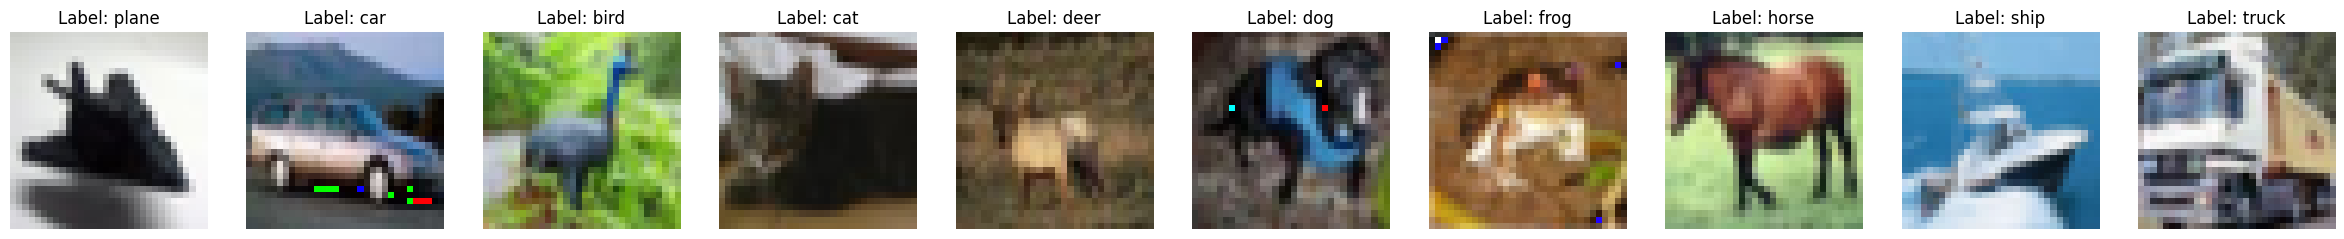

In [4]:
from torchvision.transforms import ToPILImage
import PIL.ImageOps
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(30, 12))
pil = ToPILImage()
targets = torch.tensor(train_dataset.targets)
for i in range(10):
    idx = torch.where(targets == i)[0]
    selected_idx = idx[0].item()

    image, label = train_x[selected_idx], train_y[selected_idx]
    image = pil(image)
    image = PIL.ImageOps.invert(image)

    axes[i].imshow(image)
    axes[i].set_title(f"Label: {classes[label]}")
    axes[i].axis('off')
plt.show()

## Реализация остаточной сверточной нейронной сети

Этот класс предназначен для "вытягивания" (flattening) тензоров, превращая их из многомерных в одномерные. Он будет использоваться в составе нейронных сетей для преобразования выходных данных из сверточных слоев перед подачей их на полносвязные слои.

In [5]:
import torch.nn as nn
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.view(x.size(0), -1)

Реализация остаточного блока и самой остаточной сверточной нейронной сети:

In [6]:
class ResNetBlock1(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNetBlock2(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNetBlock3(nn.Module):
    def __init__(self, out_channels, in_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.active = nn.ReLU()

    def forward(self, x):
        return self.active(self.model(x) + x)

class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_of_blocks,
                 kernel_conv_size, stride_conv,
                 kernel_pool_size, stride_pool,
                 block, lin_layers):
        super(ResNet, self).__init__()
        models = \
            [nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv)] + \
            [block(out_channels, out_channels)] * num_of_blocks + \
            [nn.MaxPool2d(kernel_pool_size, stride=stride_pool)] + \
            [nn.Flatten()]

        vect = torch.zeros(1, in_channels, 32, 32)
        for model in models:
            vect = model(vect)
        lin_dim = vect.shape[1]
        lin_dims = [lin_dim]
        for i in range(lin_layers - 1):
            if lin_dim // 2 > 10:
                lin_dims.append(lin_dim // 2)
                lin_dim = lin_dim // 2
        lin_dims.append(10)
        self.model = nn.Sequential(
            *models,
            *[nn.Linear(lin_dims[i], lin_dims[i + 1]) for i in range(len(lin_dims) - 1)]
        )

    def forward(self, x):
        return self.model(x)

    def fit(self, X, Y, lr, batch_size, epochs, logs=True):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()
            if logs:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    def predict(self, X):
        with torch.no_grad():
            return self(X).argmax(dim=1)

print(ResNet(in_channels=3,
             out_channels=6,
             num_of_blocks=2,
             kernel_conv_size=5,
             stride_conv=1,
             kernel_pool_size=2,
             stride_pool=2,
             block=ResNetBlock1,
             lin_layers=2))

ResNet(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ResNetBlock1(
      (model): Sequential(
        (0): Conv2d(6, 6, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(6, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
        (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (active): ReLU()
    )
    (2): ResNetBlock1(
      (model): Sequential(
        (0): Conv2d(6, 6, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(6, 6, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
        (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (active): ReLU()
    )
    (3): MaxPool2d(ker

Визуализация матрицы ошибок (confusion matrix) между предсказанными метками (y_pred) и истинными метками (y_true)

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def draw_confusion_matrix(y_pred, y_true):
    with torch.no_grad():
        matrix = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(matrix, display_labels=range(10)).plot(include_values=True, cmap='Blues')

## Подбор параметров

+ Подбор типа блока

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 4.369965076446533
Epoch 2/10, Loss: 3.1378915309906006
Epoch 3/10, Loss: 2.6102499961853027
Epoch 4/10, Loss: 3.3913698196411133
Epoch 5/10, Loss: 2.0731194019317627
Epoch 6/10, Loss: 2.1524832248687744
Epoch 7/10, Loss: 1.9154436588287354
Epoch 8/10, Loss: 1.6639583110809326
Epoch 9/10, Loss: 1.6397019624710083
Epoch 10/10, Loss: 0.9892045855522156


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy with block ResNetBlock1: 46.06%
Epoch 1/10, Loss: 3.731689691543579
Epoch 2/10, Loss: 3.8266406059265137
Epoch 3/10, Loss: 2.1044464111328125
Epoch 4/10, Loss: 3.4058618545532227
Epoch 5/10, Loss: 3.293931484222412
Epoch 6/10, Loss: 2.393012046813965
Epoch 7/10, Loss: 2.830873489379883
Epoch 8/10, Loss: 3.281003952026367
Epoch 9/10, Loss: 2.341895818710327
Epoch 10/10, Loss: 2.0769429206848145
Accuracy with block ResNetBlock2: 44.93%
Epoch 1/10, Loss: 5.110171794891357
Epoch 2/10, Loss: 3.8138604164123535
Epoch 3/10, Loss: 3.619570732116699
Epoch 4/10, Loss: 3.606250524520874
Epoch 5/10, Loss: 3.1888325214385986
Epoch 6/10, Loss: 2.2516214847564697
Epoch 7/10, Loss: 2.2856388092041016
Epoch 8/10, Loss: 2.7313976287841797
Epoch 9/10, Loss: 2.194354295730591
Epoch 10/10, Loss: 2.082379102706909
Accuracy with block ResNetBlock3: 41.730000000000004%
Best block: ResNetBlock1


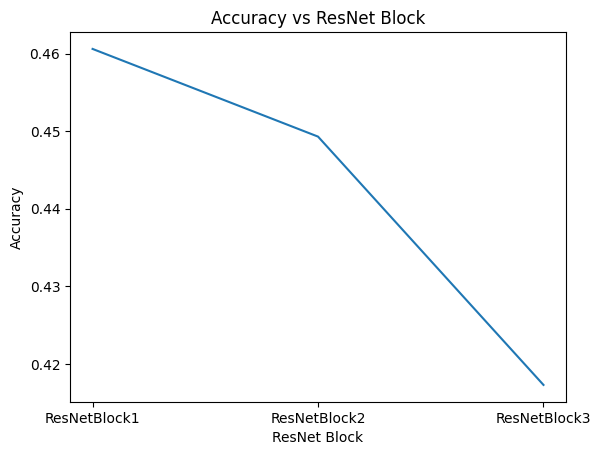

In [8]:
blocks = [ResNetBlock1, ResNetBlock2, ResNetBlock3]
accuracy_scores = []

for block in blocks:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=1,
                   kernel_conv_size=3,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=block,
                   lin_layers=2)
    model = model.to(device)
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with block {block.__name__}: {accuracy * 100}%')

max_block = blocks[accuracy_scores.index(max(accuracy_scores))]
print(f'Best block: {max_block.__name__}')

plt.plot([block.__name__ for block in blocks], accuracy_scores)
plt.xlabel('ResNet Block')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ResNet Block')
plt.show()

+ Подбор количества блоков

Epoch 1/10, Loss: 4.0754218101501465
Epoch 2/10, Loss: 3.075169563293457
Epoch 3/10, Loss: 4.03179931640625
Epoch 4/10, Loss: 3.460608720779419
Epoch 5/10, Loss: 1.8062231540679932
Epoch 6/10, Loss: 1.9998918771743774
Epoch 7/10, Loss: 1.9085966348648071
Epoch 8/10, Loss: 1.9749053716659546
Epoch 9/10, Loss: 1.9782236814498901
Epoch 10/10, Loss: 1.4897304773330688
Accuracy with block count 1: 44.3%
Epoch 1/10, Loss: 3.9850783348083496
Epoch 2/10, Loss: 3.3388137817382812
Epoch 3/10, Loss: 2.232351303100586
Epoch 4/10, Loss: 1.7467255592346191
Epoch 5/10, Loss: 1.6619333028793335
Epoch 6/10, Loss: 1.4532232284545898
Epoch 7/10, Loss: 1.5536803007125854
Epoch 8/10, Loss: 1.6035394668579102
Epoch 9/10, Loss: 1.6371216773986816
Epoch 10/10, Loss: 1.6275439262390137
Accuracy with block count 2: 51.470000000000006%
Epoch 1/10, Loss: 4.152545928955078
Epoch 2/10, Loss: 2.7538325786590576
Epoch 3/10, Loss: 2.001866340637207
Epoch 4/10, Loss: 1.9537957906723022
Epoch 5/10, Loss: 1.9925997257232

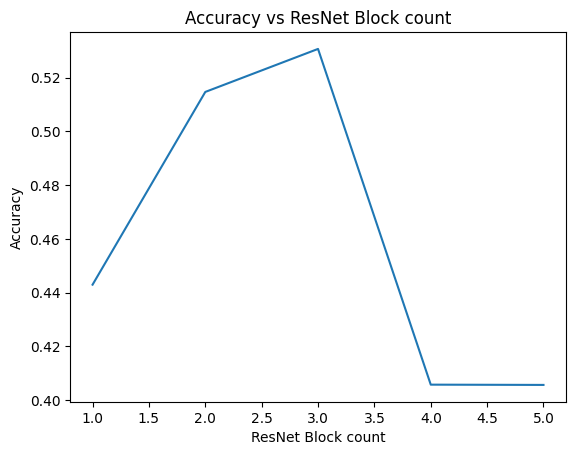

In [9]:
block_counts = range(1, 6)
accuracy_scores = []

for block_count in block_counts:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=block_count,
                   kernel_conv_size=3,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=2)
    model = model.to(device)
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with block count {block_count}: {accuracy * 100}%')

max_block_count = block_counts[accuracy_scores.index(max(accuracy_scores))]
print(f'Best block count: {max_block_count}')

plt.plot(block_counts, accuracy_scores)
plt.xlabel('ResNet Block count')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ResNet Block count')
plt.show()

+ Подбор количество слоев в полносвязном слое

Epoch 1/10, Loss: 4.28070068359375
Epoch 2/10, Loss: 5.583194255828857
Epoch 3/10, Loss: 4.450092315673828
Epoch 4/10, Loss: 4.74360466003418
Epoch 5/10, Loss: 3.796315908432007
Epoch 6/10, Loss: 2.5446717739105225
Epoch 7/10, Loss: 3.5376663208007812
Epoch 8/10, Loss: 2.7222654819488525
Epoch 9/10, Loss: 1.8644263744354248
Epoch 10/10, Loss: 3.1337554454803467
Accuracy with linear layer count 1: 43.309999999999995%
Epoch 1/10, Loss: 2.881202459335327
Epoch 2/10, Loss: 2.326140880584717
Epoch 3/10, Loss: 1.5755003690719604
Epoch 4/10, Loss: 2.78676176071167
Epoch 5/10, Loss: 1.3669825792312622
Epoch 6/10, Loss: 1.778727412223816
Epoch 7/10, Loss: 1.9594037532806396
Epoch 8/10, Loss: 1.159681797027588
Epoch 9/10, Loss: 1.9100062847137451
Epoch 10/10, Loss: 1.0927878618240356
Accuracy with linear layer count 2: 51.459999999999994%
Epoch 1/10, Loss: 1.8135732412338257
Epoch 2/10, Loss: 1.5349371433258057
Epoch 3/10, Loss: 1.3844506740570068
Epoch 4/10, Loss: 1.8644143342971802
Epoch 5/10,

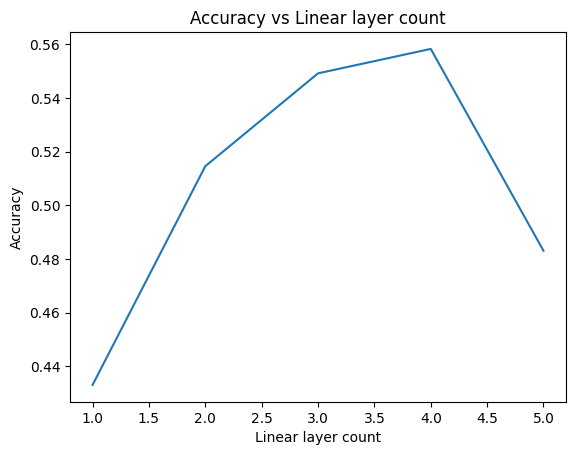

In [10]:
lin_layer_counts = range(1, 6)
accuracy_scores = []

for lin_layer_count in lin_layer_counts:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=3,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=lin_layer_count)
    model = model.to(device)
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with linear layer count {lin_layer_count}: {accuracy * 100}%')

max_lin_layer_count = lin_layer_counts[accuracy_scores.index(max(accuracy_scores))]
print(f'Best linear layer count: {max_lin_layer_count}')

plt.plot(lin_layer_counts, accuracy_scores)
plt.xlabel('Linear layer count')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Linear layer count')
plt.show()

+ Подбор *conv_kernel_sizes*:

Epoch 1/10, Loss: 2.1427111625671387
Epoch 2/10, Loss: 1.9938759803771973
Epoch 3/10, Loss: 1.7516926527023315
Epoch 4/10, Loss: 1.682631015777588
Epoch 5/10, Loss: 1.4518673419952393
Epoch 6/10, Loss: 1.468855619430542
Epoch 7/10, Loss: 1.6109659671783447
Epoch 8/10, Loss: 1.4976952075958252
Epoch 9/10, Loss: 1.2205086946487427
Epoch 10/10, Loss: 1.146937370300293
Accuracy with convolution kernel size 3: 53.89000000000001%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 1.7815308570861816
Epoch 2/10, Loss: 1.454808235168457
Epoch 3/10, Loss: 1.448099970817566
Epoch 4/10, Loss: 1.4329246282577515
Epoch 5/10, Loss: 1.7048921585083008
Epoch 6/10, Loss: 1.7169981002807617
Epoch 7/10, Loss: 1.3487132787704468
Epoch 8/10, Loss: 0.8465479612350464
Epoch 9/10, Loss: 1.0165163278579712
Epoch 10/10, Loss: 1.1482453346252441


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy with convolution kernel size 5: 56.74%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 2.001192331314087
Epoch 2/10, Loss: 1.7273244857788086
Epoch 3/10, Loss: 1.730051875114441
Epoch 4/10, Loss: 1.4015088081359863
Epoch 5/10, Loss: 1.5487991571426392
Epoch 6/10, Loss: 1.4379851818084717
Epoch 7/10, Loss: 1.1551989316940308
Epoch 8/10, Loss: 1.014453649520874
Epoch 9/10, Loss: 1.0197392702102661
Epoch 10/10, Loss: 0.9619206786155701


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy with convolution kernel size 7: 54.50000000000001%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 1.86085045337677
Epoch 2/10, Loss: 1.66310715675354
Epoch 3/10, Loss: 1.5999445915222168
Epoch 4/10, Loss: 1.781411051750183
Epoch 5/10, Loss: 1.637669563293457
Epoch 6/10, Loss: 1.5339702367782593
Epoch 7/10, Loss: 0.9395111799240112
Epoch 8/10, Loss: 1.3639415502548218
Epoch 9/10, Loss: 1.4521148204803467
Epoch 10/10, Loss: 1.5676530599594116


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Accuracy with convolution kernel size 9: 53.89000000000001%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 1.7279894351959229
Epoch 2/10, Loss: 1.4952739477157593
Epoch 3/10, Loss: 1.44464910030365
Epoch 4/10, Loss: 1.4178612232208252
Epoch 5/10, Loss: 1.2596622705459595
Epoch 6/10, Loss: 1.4241597652435303
Epoch 7/10, Loss: 1.320160984992981
Epoch 8/10, Loss: 1.1986570358276367
Epoch 9/10, Loss: 1.282878041267395
Epoch 10/10, Loss: 1.2916961908340454
Accuracy with convolution kernel size 11: 51.559999999999995%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 1.9357131719589233
Epoch 2/10, Loss: 1.4511559009552002
Epoch 3/10, Loss: 1.594473123550415
Epoch 4/10, Loss: 1.7379992008209229
Epoch 5/10, Loss: 1.757123589515686
Epoch 6/10, Loss: 1.6004955768585205
Epoch 7/10, Loss: 1.5127372741699219
Epoch 8/10, Loss: 1.6795365810394287
Epoch 9/10, Loss: 1.3549195528030396
Epoch 10/10, Loss: 1.509195327758789
Accuracy with convolution kernel size 13: 49.57%
Best convolution kernel size: 5


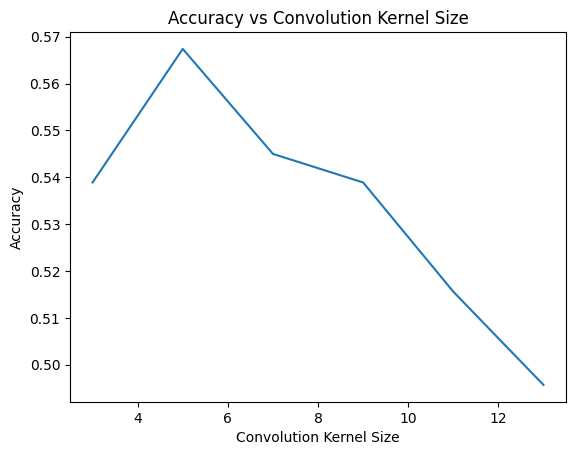

In [11]:
conv_kernel_sizes = [3, 5, 7, 9, 11, 13]
accuracy_scores = []

for conv_kernel_size in conv_kernel_sizes:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=conv_kernel_size,
                   stride_conv=1,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to(device)
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution kernel size {conv_kernel_size}: {accuracy * 100}%')

max_conv_kernel_size = conv_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution kernel size: {max_conv_kernel_size}')

plt.plot(conv_kernel_sizes, accuracy_scores)
plt.xlabel('Convolution Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Kernel Size')
plt.show()

+ Подбор *conv_stride*

Epoch 1/10, Loss: 2.0835683345794678
Epoch 2/10, Loss: 1.969372034072876
Epoch 3/10, Loss: 1.9020354747772217
Epoch 4/10, Loss: 1.5685359239578247
Epoch 5/10, Loss: 1.2711122035980225
Epoch 6/10, Loss: 1.3464033603668213
Epoch 7/10, Loss: 1.2911083698272705
Epoch 8/10, Loss: 0.9599180221557617
Epoch 9/10, Loss: 1.0821466445922852
Epoch 10/10, Loss: 1.349265694618225
Accuracy with convolution stride 1: 0.5439


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 1.897599220275879
Epoch 2/10, Loss: 1.8336317539215088
Epoch 3/10, Loss: 1.5343296527862549
Epoch 4/10, Loss: 1.6706112623214722
Epoch 5/10, Loss: 1.5769903659820557
Epoch 6/10, Loss: 1.5908114910125732
Epoch 7/10, Loss: 1.633792757987976
Epoch 8/10, Loss: 1.3175286054611206
Epoch 9/10, Loss: 1.3249540328979492
Epoch 10/10, Loss: 1.0113258361816406
Accuracy with convolution stride 2: 0.5488


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 2.1077077388763428
Epoch 2/10, Loss: 1.873917579650879
Epoch 3/10, Loss: 1.5793367624282837
Epoch 4/10, Loss: 1.4496699571609497
Epoch 5/10, Loss: 1.7330067157745361
Epoch 6/10, Loss: 1.6042996644973755
Epoch 7/10, Loss: 1.6788970232009888
Epoch 8/10, Loss: 1.4438754320144653
Epoch 9/10, Loss: 1.2811931371688843
Epoch 10/10, Loss: 1.6765718460083008
Accuracy with convolution stride 3: 0.5061
Best convolution stride: 2


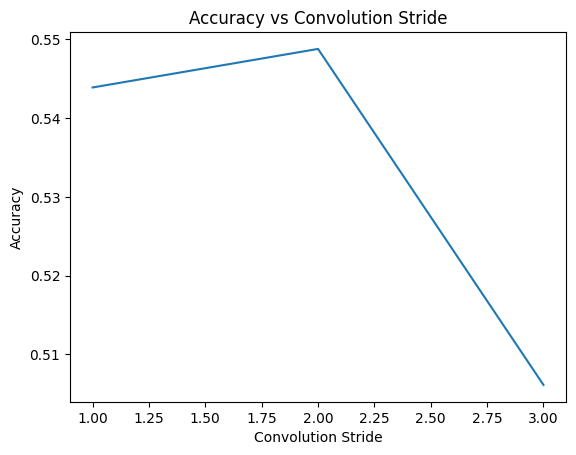

In [12]:
conv_strides = [1, 2, 3]
accuracy_scores = []

for conv_stride in conv_strides:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=conv_stride,
                   kernel_pool_size=2,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to(device)
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution stride {conv_stride}: {accuracy}')

max_conv_stride = conv_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution stride: {max_conv_stride}')

plt.plot(conv_strides, accuracy_scores)
plt.xlabel('Convolution Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Stride')
plt.show()

+ Подбор *pool_kernel_size*

Epoch 1/10, Loss: 2.111682415008545
Epoch 2/10, Loss: 1.8669918775558472
Epoch 3/10, Loss: 1.5953375101089478
Epoch 4/10, Loss: 1.9155703783035278
Epoch 5/10, Loss: 1.5215635299682617
Epoch 6/10, Loss: 1.4191627502441406
Epoch 7/10, Loss: 1.5938538312911987
Epoch 8/10, Loss: 1.3761950731277466
Epoch 9/10, Loss: 1.1330621242523193
Epoch 10/10, Loss: 1.404964566230774
Accuracy with pool kernel size 2: 0.5286
Epoch 1/10, Loss: 2.1813271045684814
Epoch 2/10, Loss: 1.7989400625228882
Epoch 3/10, Loss: 1.8102325201034546
Epoch 4/10, Loss: 1.7136555910110474
Epoch 5/10, Loss: 1.7145695686340332
Epoch 6/10, Loss: 1.5147796869277954
Epoch 7/10, Loss: 1.205617904663086
Epoch 8/10, Loss: 1.1031242609024048
Epoch 9/10, Loss: 1.4679476022720337
Epoch 10/10, Loss: 1.1479955911636353
Accuracy with pool kernel size 3: 0.5153
Epoch 1/10, Loss: 1.4325947761535645
Epoch 2/10, Loss: 1.6774784326553345
Epoch 3/10, Loss: 1.100355625152588
Epoch 4/10, Loss: 1.500952124595642
Epoch 5/10, Loss: 0.9891569614410

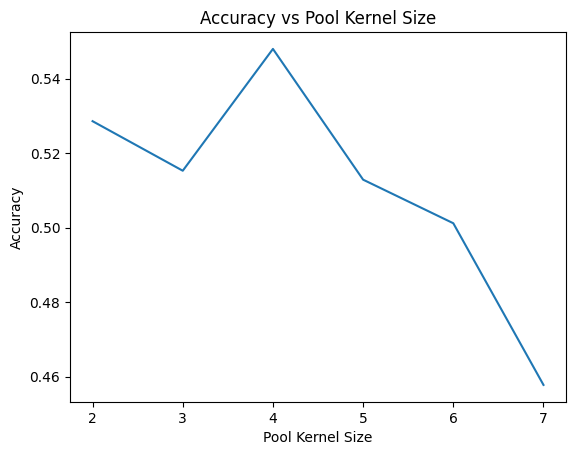

In [13]:
pool_kernel_sizes = [2, 3, 4, 5, 6, 7]
accuracy_scores = []

for pool_kernel_size in pool_kernel_sizes:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=pool_kernel_size,
                   stride_pool=2,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to(device)
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool kernel size {pool_kernel_size}: {accuracy}')

max_pool_kernel_size = pool_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool kernel size: {max_pool_kernel_size}')

plt.plot(pool_kernel_sizes, accuracy_scores)
plt.xlabel('Pool Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Kernel Size')
plt.show()


+ Подбор *pool_stride*

Epoch 1/10, Loss: 2.0622754096984863
Epoch 2/10, Loss: 1.5071592330932617
Epoch 3/10, Loss: 1.7248964309692383
Epoch 4/10, Loss: 1.4905394315719604
Epoch 5/10, Loss: 1.2079389095306396
Epoch 6/10, Loss: 1.2201251983642578
Epoch 7/10, Loss: 1.2327752113342285
Epoch 8/10, Loss: 1.1421505212783813
Epoch 9/10, Loss: 0.9261412620544434
Epoch 10/10, Loss: 1.3409533500671387
Accuracy with pool stride 1: 0.5292
Epoch 1/10, Loss: 1.836695671081543
Epoch 2/10, Loss: 1.5121794939041138
Epoch 3/10, Loss: 1.7090833187103271
Epoch 4/10, Loss: 1.643985390663147
Epoch 5/10, Loss: 1.1290558576583862
Epoch 6/10, Loss: 1.6309595108032227
Epoch 7/10, Loss: 1.2213197946548462
Epoch 8/10, Loss: 1.5541515350341797
Epoch 9/10, Loss: 1.6298080682754517
Epoch 10/10, Loss: 0.9974032640457153
Accuracy with pool stride 2: 0.5428
Epoch 1/10, Loss: 2.118166923522949
Epoch 2/10, Loss: 2.0215256214141846
Epoch 3/10, Loss: 1.9541724920272827
Epoch 4/10, Loss: 1.573747158050537
Epoch 5/10, Loss: 1.537492036819458
Epoch 

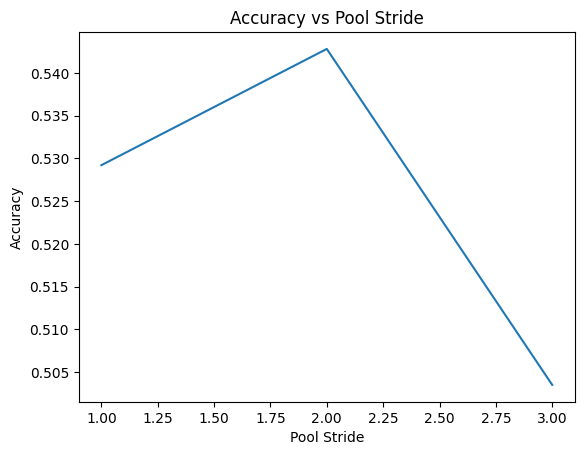

In [14]:
pool_strides = [1, 2, 3]
accuracy_scores = []

for pool_stride in pool_strides:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=max_pool_kernel_size,
                   stride_pool=pool_stride,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to(device)
    model.fit(train_x, train_y, lr=0.003, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool stride {pool_stride}: {accuracy}')

max_pool_stride = pool_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool stride: {max_pool_stride}')

plt.plot(pool_strides, accuracy_scores)
plt.xlabel('Pool Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Stride')
plt.show()


+ Подбор *learning rate*

Epoch 1/10, Loss: 2.2830801010131836
Epoch 2/10, Loss: 2.229907751083374
Epoch 3/10, Loss: 2.2648439407348633
Epoch 4/10, Loss: 2.3181161880493164
Epoch 5/10, Loss: 2.2844626903533936
Epoch 6/10, Loss: 2.329882860183716
Epoch 7/10, Loss: 2.3220603466033936
Epoch 8/10, Loss: 2.3038432598114014
Epoch 9/10, Loss: 2.2437455654144287
Epoch 10/10, Loss: 2.255751848220825
Accuracy with learning rate 0.3: 11.5%
Epoch 1/10, Loss: 1.620111107826233
Epoch 2/10, Loss: 1.2568063735961914
Epoch 3/10, Loss: 1.2080740928649902
Epoch 4/10, Loss: 1.3428899049758911
Epoch 5/10, Loss: 1.7146496772766113
Epoch 6/10, Loss: 1.1494635343551636
Epoch 7/10, Loss: 1.5357309579849243
Epoch 8/10, Loss: 1.3548698425292969
Epoch 9/10, Loss: 1.212281584739685
Epoch 10/10, Loss: 1.4984625577926636
Accuracy with learning rate 0.1: 55.05%
Epoch 1/10, Loss: 1.8803181648254395
Epoch 2/10, Loss: 1.3903663158416748
Epoch 3/10, Loss: 1.1604810953140259
Epoch 4/10, Loss: 1.0548555850982666
Epoch 5/10, Loss: 1.2608892917633057

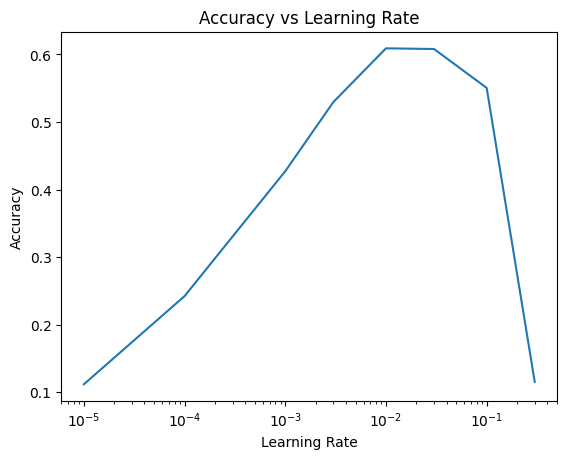

In [15]:
lrs = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0001, 0.00001]
accuracy_scores = []

for lr in lrs:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=max_pool_kernel_size,
                   stride_pool=max_pool_stride,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to(device)
    model.fit(train_x, train_y, lr=lr, batch_size=32, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with learning rate {lr}: {accuracy * 100}%')

max_lr = lrs[accuracy_scores.index(max(accuracy_scores))]
print(f'Best learning rate: {max_lr}')

plt.plot(lrs, accuracy_scores)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

+ Подбор *batch size*

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 1.0518810749053955
Epoch 2/10, Loss: 1.8471447229385376
Epoch 3/10, Loss: 1.3084840774536133
Epoch 4/10, Loss: 1.2439205646514893
Epoch 5/10, Loss: 0.872433602809906
Epoch 6/10, Loss: 0.7200047373771667
Epoch 7/10, Loss: 1.382144570350647
Epoch 8/10, Loss: 0.9982812404632568
Epoch 9/10, Loss: 1.181281566619873
Epoch 10/10, Loss: 1.137289047241211
Accuracy with batch size 16: 60.85%
Epoch 1/10, Loss: 1.3937054872512817
Epoch 2/10, Loss: 1.379765272140503
Epoch 3/10, Loss: 1.352049469947815
Epoch 4/10, Loss: 1.1341131925582886
Epoch 5/10, Loss: 1.5779186487197876
Epoch 6/10, Loss: 1.0974568128585815
Epoch 7/10, Loss: 1.066591501235962
Epoch 8/10, Loss: 1.2188583612442017
Epoch 9/10, Loss: 1.2771416902542114
Epoch 10/10, Loss: 1.0836408138275146
Accuracy with batch size 32: 59.25%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 1.9502232074737549
Epoch 2/10, Loss: 1.5876376628875732
Epoch 3/10, Loss: 1.385768175125122
Epoch 4/10, Loss: 1.3182666301727295
Epoch 5/10, Loss: 1.3984490633010864
Epoch 6/10, Loss: 1.277001142501831
Epoch 7/10, Loss: 1.2426668405532837
Epoch 8/10, Loss: 1.1316555738449097
Epoch 9/10, Loss: 1.0996627807617188
Epoch 10/10, Loss: 0.9739851355552673
Accuracy with batch size 64: 57.48%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 2.934835195541382
Epoch 2/10, Loss: 1.7630757093429565
Epoch 3/10, Loss: 1.8323183059692383
Epoch 4/10, Loss: 1.5291070938110352
Epoch 5/10, Loss: 1.540747880935669
Epoch 6/10, Loss: 1.470789909362793
Epoch 7/10, Loss: 1.2613202333450317
Epoch 8/10, Loss: 1.2968831062316895
Epoch 9/10, Loss: 1.2812939882278442
Epoch 10/10, Loss: 1.2610887289047241
Accuracy with batch size 128: 54.449999999999996%


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Loss: 2.3308372497558594
Epoch 2/10, Loss: 2.0074760913848877
Epoch 3/10, Loss: 1.9324239492416382
Epoch 4/10, Loss: 1.5536843538284302
Epoch 5/10, Loss: 1.5691999197006226
Epoch 6/10, Loss: 1.545656681060791
Epoch 7/10, Loss: 1.5685449838638306
Epoch 8/10, Loss: 1.430929183959961
Epoch 9/10, Loss: 1.2787891626358032
Epoch 10/10, Loss: 1.3758739233016968
Accuracy with batch size 256: 49.09%
Best batch size: 16


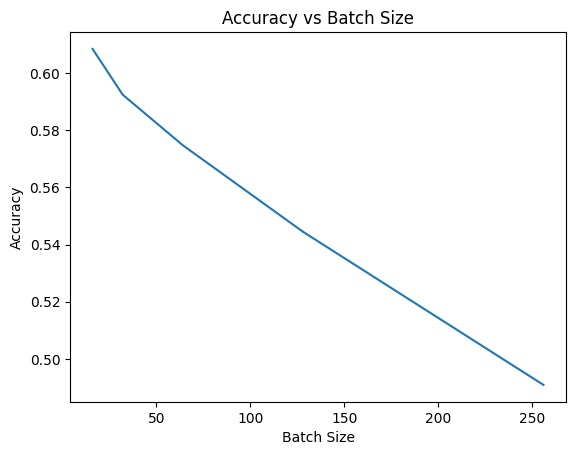

In [16]:
batch_sizes = [16, 32, 64, 128, 256]
accuracy_scores = []

for batch_size in batch_sizes:
    model = ResNet(in_channels=3,
                   out_channels=25,
                   num_of_blocks=max_block_count,
                   kernel_conv_size=max_conv_kernel_size,
                   stride_conv=max_conv_stride,
                   kernel_pool_size=max_pool_kernel_size,
                   stride_pool=max_pool_stride,
                   block=max_block,
                   lin_layers=max_lin_layer_count)
    model = model.to(device)
    model.fit(train_x, train_y, lr=max_lr, batch_size=batch_size, epochs=10)
    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with batch size {batch_size}: {accuracy * 100}%')

max_batch_size = batch_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best batch size: {max_batch_size}')

plt.plot(batch_sizes, accuracy_scores)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')
plt.show()

+ Подбор *epochs*

Block: ResNetBlock1
Block count: 3
Linear layer count: 4
Convolution kernel size: 5
Convolution stride: 2
Pool kernel size: 4
Pool stride: 2
Learning rate: 0.01
Batch size: 16

Iteration: 1
Epoch 1/10, Loss: 2.5974464416503906
Epoch 2/10, Loss: 2.0296807289123535
Epoch 3/10, Loss: 1.884332299232483
Epoch 4/10, Loss: 1.6579267978668213
Epoch 5/10, Loss: 1.5867079496383667
Epoch 6/10, Loss: 1.6574443578720093
Epoch 7/10, Loss: 1.4216437339782715
Epoch 8/10, Loss: 1.4473137855529785
Epoch 9/10, Loss: 1.3886245489120483
Epoch 10/10, Loss: 1.3141518831253052
Accuracy: 50.28%
Iteration: 2
Epoch 1/10, Loss: 1.33668053150177
Epoch 2/10, Loss: 1.438594102859497
Epoch 3/10, Loss: 1.355954647064209
Epoch 4/10, Loss: 1.2902199029922485
Epoch 5/10, Loss: 1.2564315795898438
Epoch 6/10, Loss: 1.2381517887115479
Epoch 7/10, Loss: 1.2785489559173584
Epoch 8/10, Loss: 1.1291764974594116
Epoch 9/10, Loss: 1.1885040998458862
Epoch 10/10, Loss: 1.2248873710632324
Accuracy: 55.38999999999999%
Iteration: 3
E

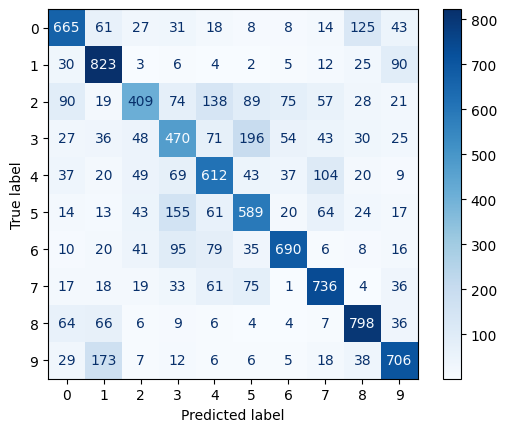

In [17]:
print(f'Block: {max_block.__name__}')
print(f'Block count: {max_block_count}')
print(f'Linear layer count: {max_lin_layer_count}')
print(f'Convolution kernel size: {max_conv_kernel_size}')
print(f'Convolution stride: {max_conv_stride}')
print(f'Pool kernel size: {max_pool_kernel_size}')
print(f'Pool stride: {max_pool_stride}')
print(f'Learning rate: {max_lr}')
print(f'Batch size: {max_batch_size}\n')

model = ResNet(in_channels=3,
               out_channels=25,
               num_of_blocks=max_block_count,
               kernel_conv_size=max_conv_kernel_size,
               stride_conv=max_conv_stride,
               kernel_pool_size=max_pool_kernel_size,
               stride_pool=max_pool_stride,
               block=max_block,
               lin_layers=max_lin_layer_count)
model = model.to(device)

for i in range(20):
    print(f'Iteration: {i+1}')
    model.fit(train_x, train_y, lr=max_lr, batch_size=batch_size, epochs=10)

    with torch.no_grad():
        pred = model.predict(test_x).cpu().numpy()
        test_y_labels = test_y.cpu().numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy: {accuracy * 100}%')

        if accuracy > 0.9:
          break

with torch.no_grad():
    pred = model.predict(test_x).cpu().numpy()
    test_y_labels = test_y.cpu().numpy()
    draw_confusion_matrix(pred, test_y_labels)